In [1]:
####Housing Price####

#######Downloading the dataset#######

#Importing the libraries
import os
import tarfile
from six.moves import urllib

#Setting the site/download url
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = "datasets/housing"
HOUSING_URL = DOWNLOAD_ROOT+HOUSING_PATH+"/housing.tgz"

#Fetching the dataset from the site(to avoid using special access)
def fetch_housing_data(housing_url = HOUSING_URL, housing_path = HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path,"housing.tgz")
    urllib.request.urlretrieve(housing_url,tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path = housing_path)
    housing_tgz.close()
    
####################################

In [2]:
#######Loading the dataset#######

#Importing the libraries
import pandas as pd
import numpy as np

#Loading the data using pandas
def load_housing_data(housing_path = HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

#################################

In [3]:
#######Taking a quick look at the data#######


housing = load_housing_data()
#housing.head() #To show first five rows of the dataset, we could pass a value to show more or less
#housing.info()
#housing["ocean_proximity"].value_counts()
#housing.describe()
#housing

##############################################

In [4]:
#######Visualizing the dataset#######

#Importing the libraries
import matplotlib.pyplot as plt
%matplotlib inline 

#housing.hist(bins = 50, figsize = (20,15))
#plt.show()

#####################################

In [5]:
#######Splitting the data into training and test sets#######

#Importing the libraries
#from sklearn.model_selection import train_test_split

#Splitting the dataset
#train_set, test_set = train_test_split(housing, test_size = 0.2, random_state = 42)

############################################################

In [6]:
#######Categorizing the dataset based on median income#######

#Importing the libraries
from sklearn.model_selection import StratifiedShuffleSplit as stsplit

#Categorizing the data
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing["income_cat"].where(housing["income_cat"]<5, 5.0, inplace = True)

#Performing Stratified shuffle split
split = stsplit(n_splits = 1, test_size=0.2, random_state = 42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]
    
#Droping the income_cat column as it is no longer necessary
for set_ in(strat_train_set, strat_test_set):
    set_.drop("income_cat",axis = 1, inplace = True)
    
#Keeping a copy of the training set
housing = strat_train_set.copy()
#housing

#housing.hist(bins = 50, figsize = (20,15))
#plt.show()

#############################################################

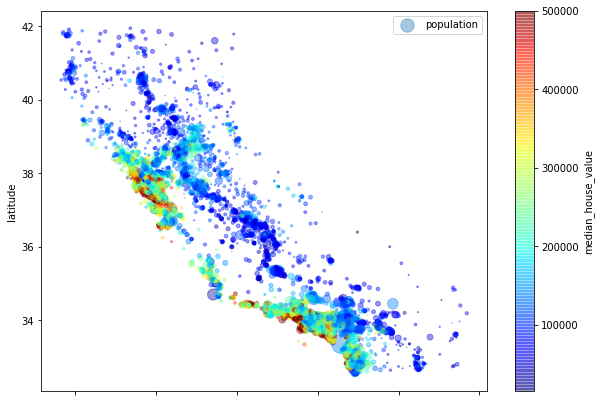

In [7]:
#######Visualizing the training set#######

#housing.plot(kind="scatter", x = "longitude", y = "latitude", alpha=0.1)
housing.plot(kind="scatter", x = "longitude", y = "latitude", alpha = 0.4,
            s = housing["population"]/100, label = "population", figsize=(10,7),
            c = "median_house_value", cmap = plt.get_cmap("jet"), colorbar = True)

#plt.legend()
##########################################

In [8]:
#######Attribute Combination#######

#housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
#housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
#housing["population_per_household"] = housing["population"]/housing["households"]
#remember that doing so will also affect the test and training set because all the data is made available from a paticular address

###################################

In [8]:
########Preparing data for ML Algorithms#######

housing = strat_train_set.drop("median_house_value", axis = 1)
housing_labels = strat_train_set["median_house_value"].copy()

###############################################

In [9]:
#######Data Cleaning#######

#Importing the libraries
#from sklearn.preprocessing import Imputer

#Taking care of missing data
#imputer = Imputer(strategy = "median")

#Taking numeric part of the dataset
housing_num = housing.drop("ocean_proximity", axis = 1)
#imputer.fit(housing_num)
#X = imputer.transform(housing_num) #Numpy array with all the transformed features

#Using a pandas dataframe to store the transformed features
#housing_tr = pd.DataFrame(X, columns = housing_num.columns)
#housing_tr

###########################

In [10]:
#######Taking cae of Categorical Data#######

#Importing the Libraries
#from sklearn.preprocessing import LabelBinarizer #We get a numpy array in return by default

#Considering the column which is to be encoded
housing_cat = housing["ocean_proximity"]

#Forming the categorical data
#encoder = LabelBinarizer()
#housing_cat_1hot = encoder.fit_transform(housing_cat)
#housing_cat_1hot
#housing

############################################


In [11]:
#######Custom Transformer to add Extra Attributes#######

#Importing the libraries
from sklearn.base import BaseEstimator, TransformerMixin

#Setting the Indices
rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

#Defining the class
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): #No *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix]/X[:, household_ix]
        population_per_household = X[:, population_ix]/X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix]/X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
        
#Combing the attributes together
#attr_adder = CombinedAttributesAdder()
#housing_extra_attribs = attr_adder.transform(housing.values)
#housing_extra_attribs[0]

#####################################

In [12]:
#######Custom DataFrame Selector#######

#Importing the libraries
from sklearn.base import BaseEstimator, TransformerMixin

#Defining the class
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        selection = X[self.attribute_names]
        return selection.values

###################################

In [13]:
#######Custom Label Binarizer#######
#Latest version of scikit does support pipelining the Label binarizer

#Importing the Libraries
from sklearn.preprocessing import LabelBinarizer
from sklearn.base import BaseEstimator, TransformerMixin

#Defining the new Label Binarizer class
class LabelBinarizer_new(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        encoder = LabelBinarizer()
        return encoder.fit_transform(X)
        
####################################

In [34]:
#encoder = LabelEncoder()
#encoder2 = OneHotEncoder()
#housing_cat_encoded = encoder.fit_transform(housing_cat)
#housing_cat_1hot = encoder2.fit_transform(housing_cat_encoded.reshape(-1,1))
#housing_cat_1hot.toarray()

In [14]:
########Transformer Pipelines#######

#Importing the libraries 
from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import Imputer 
from sklearn.preprocessing import StandardScaler

#Separating the parts: Numeric type from categorical 
num_attribs = list(housing_num) #We get the labels of the columns 
cat_attribs = ["ocean_proximity"]

#Pipelining all the data transformations 
num_pipeline = Pipeline([ ('selector', DataFrameSelector(num_attribs)), 
                         ('imputer', Imputer(strategy = "median")), 
                         ('attribs_adder', CombinedAttributesAdder()), 
                         ('std_scaler', StandardScaler()), 
                        ])

cat_pipeline = Pipeline([ ('selector', DataFrameSelector(cat_attribs)), 
                         ('label_binarizer', LabelBinarizer_new()),
                        ])
####################################

In [15]:
#######Combining the two pipelines#######

#Importing the libraries
from sklearn.pipeline import FeatureUnion

#Combining the pipelines
full_pipeline = FeatureUnion(transformer_list = [
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline),
])

#########################################

In [16]:
housing_prepared = full_pipeline.fit_transform(housing)
#housing_prepared[:5]
housing_prepared[1]

array([-1.17602483,  0.6596948 , -1.1653172 , -0.90896655, -1.0369278 ,
       -0.99833135, -1.02222705,  1.33645936,  0.21768338, -0.03353391,
       -0.83628902,  1.        ,  0.        ,  0.        ,  0.        ,  0.        ])

In [17]:
#####Training a Linear Regression Model#####

#Importing the Libraries
from sklearn.linear_model import LinearRegression

#Training the Model
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

#Getting the predictions on the training set
some_data = housing_prepared[:5]
some_labels = housing_labels.iloc[:5]
#some_data_prepared = full_pipeline.fit_transform(some_data)
#housing_prepared[:5]
#some_data_prepared
#housing_cat
print(lin_reg.predict(some_data))
print(list(some_labels))

############################################

[ 210644.60459286  317768.80697211  210956.43331178   59218.98886849
  189747.55849879]
[286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [18]:
#####Scores of Linear Regression######

#Importing the libraries
from sklearn.metrics import mean_squared_error as mse

#Finding the scores
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mse(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

######################################

68628.198198489234

In [19]:
#####Training a Decision Tree model######

#Importing the libraries
from sklearn.tree import DecisionTreeRegressor

#Training the model
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

#Predicting the outcomes
housing_predictions_dt = tree_reg.predict(housing_prepared)
tree_mse = mse(housing_labels, housing_predictions_dt)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

#########################################

0.0

In [20]:
####Training a Random Forest Regressor####

#Importing the libraries
from sklearn.ensemble import RandomForestRegressor

#Traing the model
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

#Preedicting the outcomes
forest_predictions = forest_reg.predict(housing_prepared)
forest_mse = mse(housing_labels, forest_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

##########################################

22248.695864293259

In [21]:
####Cross Validation####

#Importing the libraries
from sklearn.model_selection import cross_val_score as cvs

#Finding scores  for Decision Tree
scores = cvs(tree_reg, housing_prepared, housing_labels, scoring = "neg_mean_squared_error", cv = 10)
tree_rmse_scores = np.sqrt(-scores)

#Finding scores for Linear Regression Model
lin_scores = cvs(lin_reg, housing_prepared, housing_labels, scoring = "neg_mean_squared_error", cv = 10)
lin_rmse_scores = np.sqrt(-lin_scores)

#Finding scores for Random Forest Regression
forest_scores = cvs(forest_reg, housing_prepared, housing_labels, scoring = "neg_mean_squared_error", cv = 10)
forest_rmse_scores = np.sqrt(-forest_scores)

########################

In [22]:
####Cross Validaton Results####

def display_scores(scores):
    print("Scores: ", scores)
    print("Mean: ",scores.mean())
    print("Standard Deviation: ", scores.std())
    
display_scores(tree_rmse_scores)
print()
display_scores(lin_rmse_scores)
print()
display_scores(forest_rmse_scores)
###############################

Scores:  [ 69458.37223058  67843.50724978  70028.13826103  69428.43386705
  71481.9303537   74737.50660277  70522.79861814  71367.50169144
  78904.58869842  70314.0139173 ]
Mean:  71408.679149
Standard Deviation:  3026.5707007

Scores:  [ 66782.73843989  66960.118071    70347.95244419  74739.57052552
  68031.13388938  71193.84183426  64969.63056405  68281.61137997
  71552.91566558  67665.10082067]
Mean:  69052.4613635
Standard Deviation:  2731.6740018

Scores:  [ 52474.2843596   50694.62543022  51962.52967308  54373.10632609
  52634.57293828  53815.0725317   53002.3863491   50806.976015
  55225.35017704  52843.34049079]
Mean:  52783.2244291
Standard Deviation:  1366.27024037


In [ ]:
####Carryin out Grid Search####

#Importing the libraries
from sklearn.model_selection import GridSearchCV

#Tuning the hyperparameters
param_grid = [
    {'n_estimators': [3,10,30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap' : [False], 'n_estimators' : [3, 10], 'max_features': [2, 3, 4]},
]

forest_reg_mod = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg_mod, param_grid, cv = 5,
                          scoring = 'neg_mean_squared_error')

grid_search.fit(housing_prepared, housing_labels)

###############################

In [34]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [35]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [37]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

64591.6849502 {'max_features': 2, 'n_estimators': 3}
55407.6253269 {'max_features': 2, 'n_estimators': 10}
52980.0303305 {'max_features': 2, 'n_estimators': 30}
60563.6645239 {'max_features': 4, 'n_estimators': 3}
52833.5715898 {'max_features': 4, 'n_estimators': 10}
50779.5464273 {'max_features': 4, 'n_estimators': 30}
59246.0271295 {'max_features': 6, 'n_estimators': 3}
52297.0618955 {'max_features': 6, 'n_estimators': 10}
50054.7146764 {'max_features': 6, 'n_estimators': 30}
59456.0859033 {'max_features': 8, 'n_estimators': 3}
51801.0694367 {'max_features': 8, 'n_estimators': 10}
49966.9643308 {'max_features': 8, 'n_estimators': 30}
61963.6795521 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54589.827002 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
58972.1133642 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
53004.6365984 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10}
59036.1944344 {'bootstrap': False, 'max_features': 4, 'n_estima

In [39]:
####Evaluating on Test Set####

final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis = 1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mse(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

##############################

48148.083280368191